# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('General Demographics\n', azdias.shape,'\n',azdias.head(),'\n')

print('Feature Summary\n', feat_info.shape,'\n',feat_info.head(),'\n')

General Demographics
 (891221, 85) 
    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         Na

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
for row in feat_info.itertuples():
    missing_or_unknown = row.missing_or_unknown.strip('[]').split(',')
    missing_or_unknown = [int(value) if (value.lstrip('-').isdigit()) else value.strip(' "\'') for value in missing_or_unknown if value]
    if missing_or_unknown != []:
        azdias[row.attribute] = azdias[row.attribute].replace(missing_or_unknown, np.nan)

In [6]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

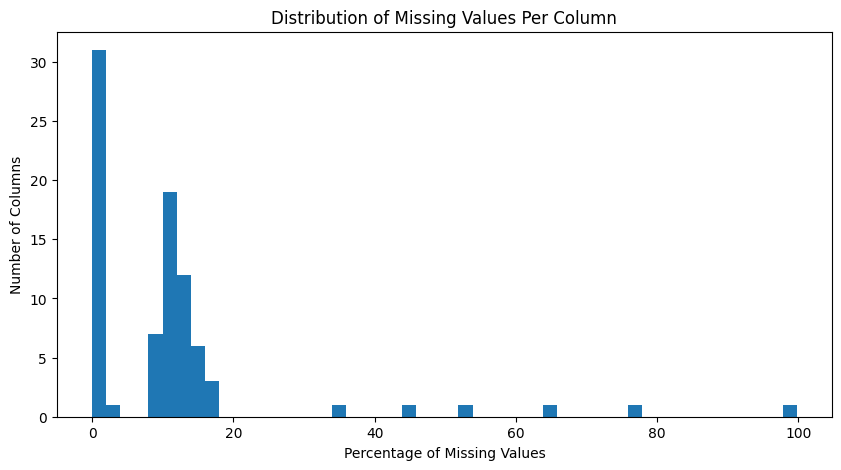

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#get percentage of missing values per column
missing_column_percent = azdias.isnull().mean() * 100

#plot histogram of missing col percent
plt.figure(figsize=(10,5))
plt.hist(missing_column_percent,bins=50)
plt.title('Distribution of Missing Values Per Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show()

In [8]:
# Investigate patterns in the amount of missing data in each column.
drop_threshold = 30
pattern_threshold = 5

#identify columns to be dropped due to large amount of missing data.
columns_to_drop = missing_column_percent[missing_column_percent > drop_threshold].index

#print columns going to be dropped
print('Columns to be dropped due to high percentage of missing data:\n')
print(missing_column_percent[missing_column_percent > drop_threshold])

#find patterns in remaining columns
print('\nPossible patterns in missing data for remaining columns:\n')
pattern_columns = missing_column_percent[(missing_column_percent > pattern_threshold) & (missing_column_percent <= drop_threshold)]
print(pattern_columns.sort_values())

Columns to be dropped due to high percentage of missing data:

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

Possible patterns in missing data for remaining columns:

ANZ_PERSONEN              8.247000
WOHNDAUER_2008            8.247000
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
GEBAEUDETYP_RASTER       10.452514
INNENSTADT               10.518154
EWDICHTE                 10.518154
BALLRAUM                 10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
RELAT_AB                 10.926022
ARBEIT                   10.926022
LP_LEBE

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(columns=columns_to_drop, inplace=True)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The columns to be dropped have over 30% of their data missing. The remaining columns with over 5% data missing appear to have some relationships to each other. As shown in the data above, several columns have the identical amount of data missing such as, WOHNDAUER_2008 and SOHO_KZ missing 8.247% of data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [10]:
# How much data is missing in each row of the dataset?

#calculate missing data in each row
missing_row_percent = azdias.isnull().sum(axis=1)

# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#set threshold for data split in this instance 50th percentile
row_threshold = missing_row_percent.quantile(0.50)

#split data based on threshold
lower_missing_set = azdias[missing_row_percent <= row_threshold]
higher_missing_set = azdias[missing_row_percent > row_threshold]

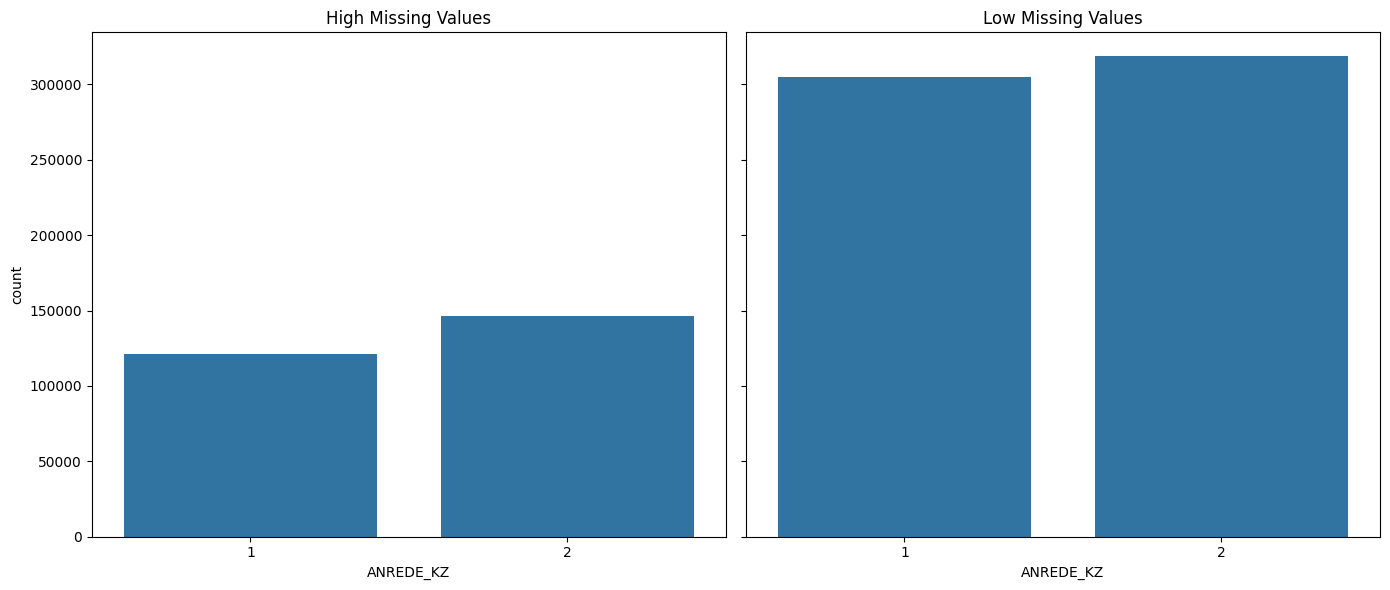

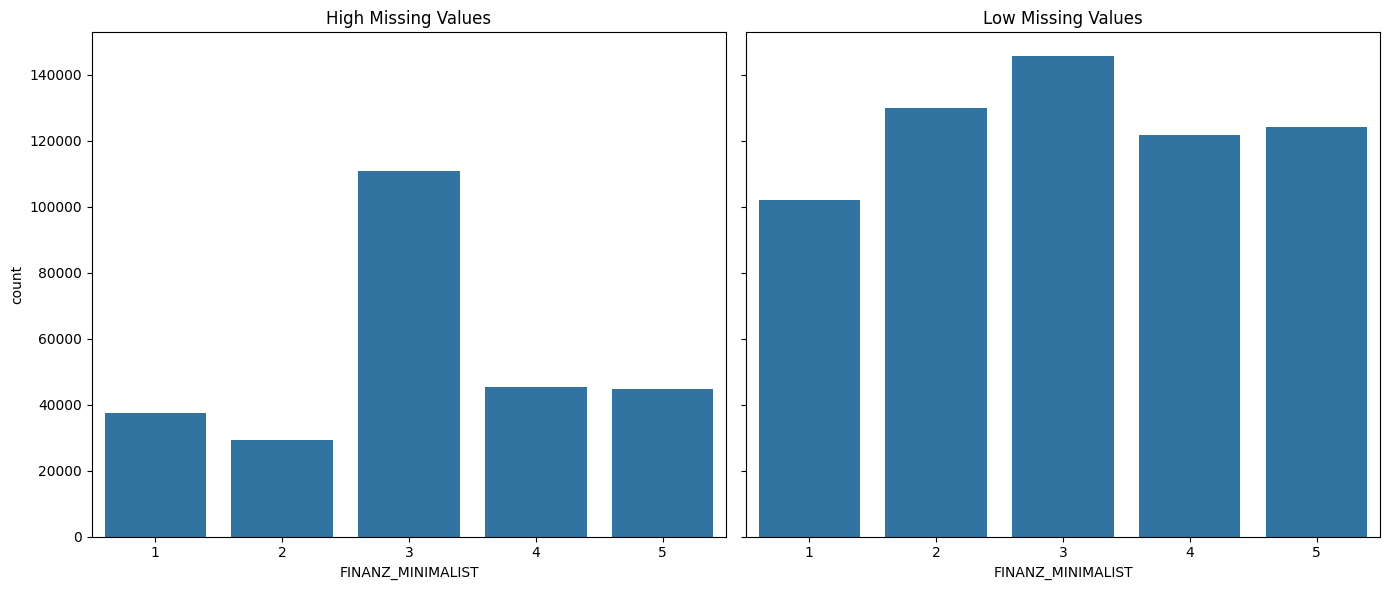

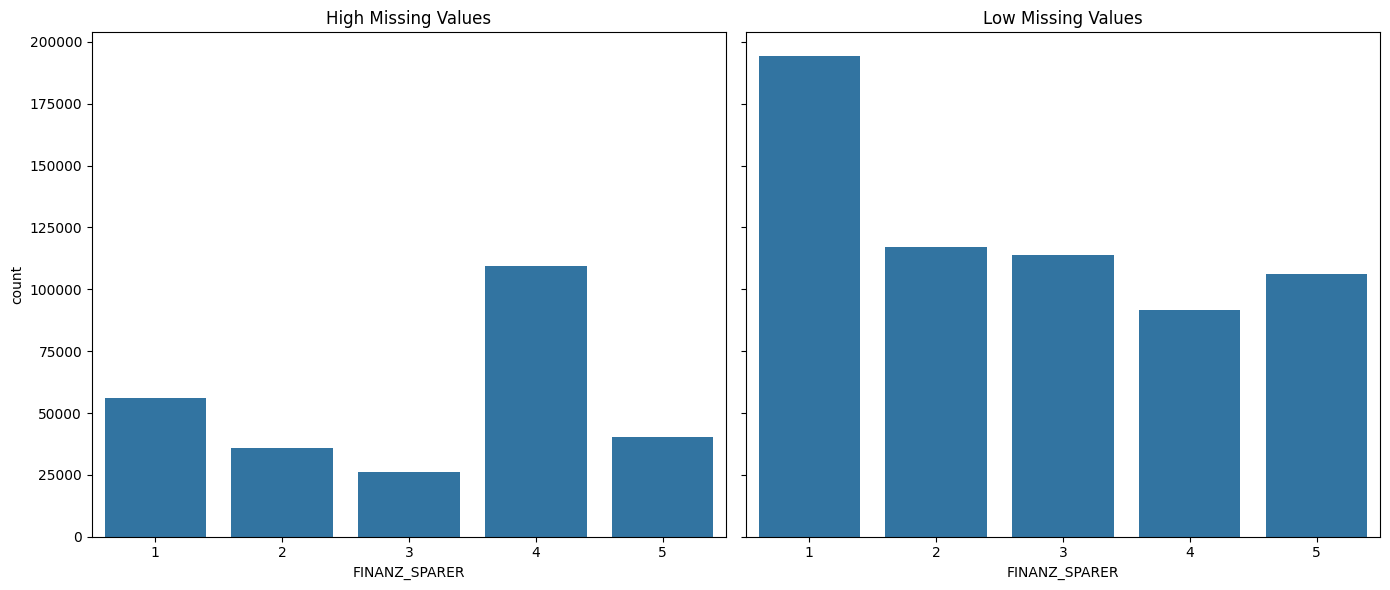

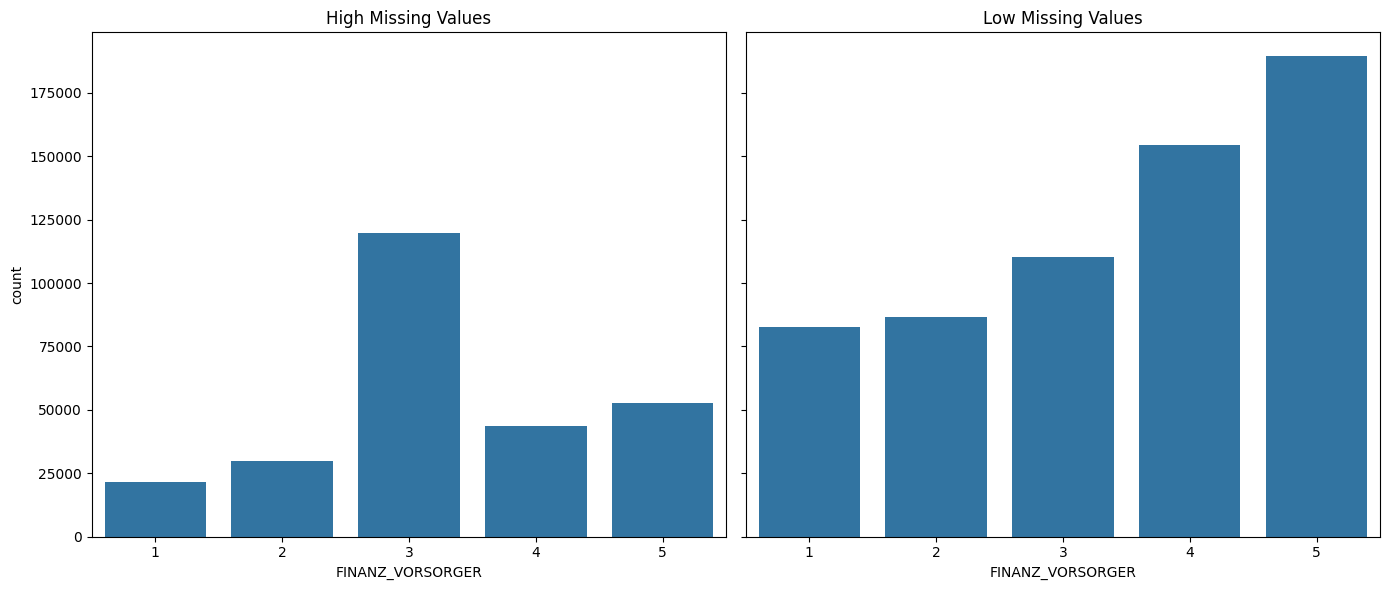

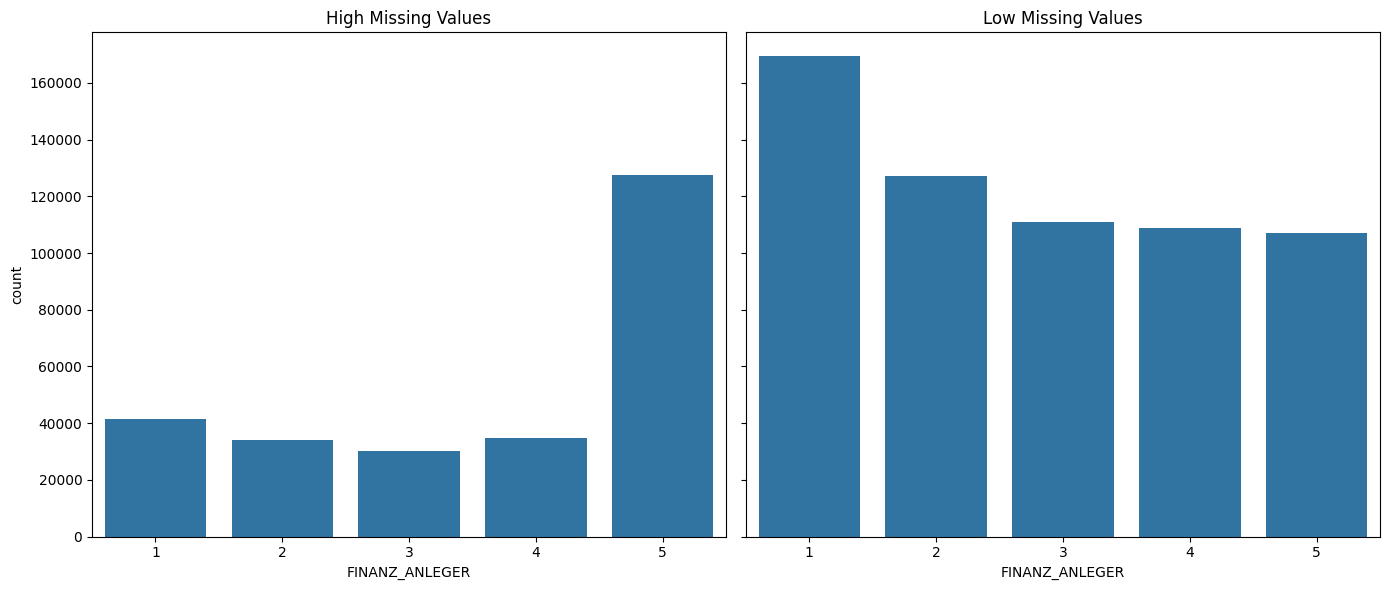

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distributions(higher_missing_set, lower_missing_set,column):
    fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharey=True)
    
    #plot high set
    sns.countplot(x=column, data=higher_missing_set, ax=axs[0])
    axs[0].set_title('High Missing Values')
    
    #plot low set
    sns.countplot(x=column, data=lower_missing_set, ax=axs[1])    
    axs[1].set_title('Low Missing Values')
    
    plt.tight_layout()
    plt.show()
    
#columns with no missing data 
columns_no_missing = missing_column_percent[missing_column_percent==0].index.tolist()

#select first 5
columns_to_compare = columns_no_missing[:5]

for column in columns_to_compare:
    compare_distributions(higher_missing_set,lower_missing_set,column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

The first column shown above ANREDE_KZ shows a similar distribution between the two subsets of data. The remaining columns do not appear to have similar distributions for each subset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?

feature_type_counts = feat_info['type'].value_counts()
print(feature_type_counts)

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#select categorical features
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']

#intialize lists to store variable names
numeric_binary_vars = []
non_numeric_binary_vars = []
multi_vars = []

#determine binary and multi-level features
for feature in categorical_features:
    try:
        #get unique non-na values
        unique_values = azdias[feature].dropna().unique()

        #binary check
        if len(unique_values) == 2:
            #check if numeric
            if np.issubdtype(azdias[feature].dtype, np.number):
                numeric_binary_vars.append(feature)
            else:
                non_numeric_binary_vars.append(feature)

        #otherwise its multi level
        else:
            multi_vars.append(feature)
    except KeyError:
        #handle keyerrors eg columns dropped from data frame
        print(f'Column {feature} not found in dataframe')
        continue


print(f'Numeric Binary Vars: {numeric_binary_vars}')
print(f'Non-numeric Binary Vars: {non_numeric_binary_vars}')
print(f'Multi-level Vars: {multi_vars}')

Column AGER_TYP not found in dataframe
Column TITEL_KZ not found in dataframe
Column KK_KUNDENTYP not found in dataframe
Numeric Binary Vars: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Non-numeric Binary Vars: ['OST_WEST_KZ']
Multi-level Vars: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [15]:
#Before re-encoding, drop all rows containing NaN for easier transformation
#As well as the future model

print(azdias.shape)
azdias = azdias.dropna()
print(azdias.shape)

(623209, 79)
(623209, 79)


In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn.preprocessing import LabelEncoder

#re-encode binary non-numeric variables with LabelEncoder
for feature in non_numeric_binary_vars:
    le = LabelEncoder()
    azdias[feature] = le.fit_transform(azdias[feature])
    
#re-encode multi-level variables with pandas
for feature in multi_vars:
    #create dummy vars
    dummies = pd.get_dummies(azdias[feature], prefix=feature)
    #concatenate dummies to original df
    azdias = pd.concat([azdias, dummies], axis=1)
    #drop original feature
    azdias.drop(feature, axis=1, inplace=True)


In [17]:
print(azdias.shape)

(623209, 191)


#### Discussion 1.2.1: Re-Encode Categorical Features

The majority of the categorical features were multi-level which were converted using dummies. One categorical feature was a binary non-numeric and transformed with LabelEncoder. The remaining features were already binary and numeric or was previously dropped from the data.

All other columns were kept but all rows containing NaN were dropped prior to re-encoding the categorical features. This resulted in a loss of ~193,000 rows but was done for simplicity of re-encoding and the learning model.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def get_decade(x):
    '''
    Function to extract decade based off data dictionary information
    INPUT: PRAEGENDE_JUGENDJAHRE
    OUTPUT: Decade
    '''
    if x in [1, 2]:
        return 40
    if x in [3, 4]:
        return 50
    if x in [5, 6, 7]:
        return 60
    if x in [8, 9]:
        return 70
    if x in [10, 11, 12, 13]:
        return 80
    if x in [14, 15]:
        return 90
    return np.nan #for missing values


def get_movement(x):
    '''
    Function to extract movement based off data dictionary information
    INPUT: PRAEGENDE_JUGENDJAHRE
    OUTPUT: Movement
    '''
    if x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 1  # Avantgarde
    if x in [1, 3, 5, 8, 10, 12, 14]:
        return 0  # Mainstream
    return np.nan #for missing values

In [19]:
#apply functions 
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)


In [20]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def get_wealth(x):
    '''
    Function to extract wealth based off data dictionary information
    INPUT: CAMEO_INTL_2015
    OUTPUT: Wealth
    '''
    if pd.isnull(x):
        return np.nan
    return int(str(x)[0]) #extract first digit

def get_life_stage(x):
    '''
    Function to extract life stage based off data dictionary information
    INPUT: CAMEO_INTL_2015
    OUTPUT: Life stage
    '''
    if pd.isnull(x):
        return np.nan
    return int(str(x)[1]) #extract second digit



In [21]:
#apply functions
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(get_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(get_life_stage)



In [23]:
print(azdias.shape)
#Remaining mixed features will be dropped due to concern for the workspaces memory
#and computational power with current feature space
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']
print('Mixed features to be dropped: ', mixed_features.tolist())

for feature in mixed_features:
    try:
        azdias.drop(feature, axis=1, inplace=True)
        print(f'Dropped feature: {feature}')
    except KeyError:
        print(f'Feature {feature} not found in DataFrame.')

(623209, 195)
Mixed features to be dropped:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
Dropped feature: LP_LEBENSPHASE_FEIN
Dropped feature: LP_LEBENSPHASE_GROB
Dropped feature: PRAEGENDE_JUGENDJAHRE
Dropped feature: WOHNLAGE
Dropped feature: CAMEO_INTL_2015
Feature KBA05_BAUMAX not found in DataFrame.
Dropped feature: PLZ8_BAUMAX


#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were kept and had their values split accordingly from the instructions and data dictionary. Functions were built around the columns requirements and applied to the column. Then the original column was dropped along with the remaining mixed types. This was done to prevent the feature space from further expanding to save memory, time, computational power, and prevent errors from workspace limitations.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [20]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [21]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    for row in feat_info.itertuples():
        try:
            missing_or_unknown = row.missing_or_unknown.strip('[]').split(',')
            missing_or_unknown = [int(value) if (value.lstrip('-').isdigit()) else value.strip(' "\'') for value in missing_or_unknown if value]
            if missing_or_unknown != []:
                df[row.attribute] = df[row.attribute].replace(missing_or_unknown, np.nan)
        except KeyError:
            continue
    
    #drop column with large amount of missing data
    df.drop(columns=columns_to_drop, inplace=True)
    df = df.dropna()
    #re-encode binary non-numeric variables with LabelEncoder
    for feature in non_numeric_binary_vars:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])

    #re-encode multi-level variables with pandas
    for feature in multi_vars:
        #create dummy vars
        dummies = pd.get_dummies(df[feature], prefix=feature)
        #concatenate dummies to original df
        df = pd.concat([df, dummies], axis=1)
        #drop original feature
        df.drop(feature, axis=1, inplace=True)

    #apply mixed functions
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(get_wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(get_life_stage)

    #drop mixed features and rows with missing values
    df.drop(mixed_features, axis=1, inplace=True, errors='ignore')
    df.dropna(inplace=True)
    
    #ensure structure of returned frame matches azdias for scaling
    missing_cols = [col for col in azdias.columns if col not in df.columns]
    
    #if column is missing due to feature not having a certain val before re-encoding
    #set to 0
    for col in missing_cols:
        df[col] = 0 
    
    #ensure order matches
    df = df[azdias.columns]
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [25]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isna().sum().sum()

0

In [26]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns=azdias.columns)

### Discussion 2.1: Apply Feature Scaling

Rows that contained missing data were removed from the data, despite the loss of these rows, the data frame contains a substantial amount of data and rows. This should minimize the impact of the row removal and allow the workspace to complete the upcoming tasks more efficiently.

The standard scaler was chosen for feature scaling due to its straightforward implementation and effectiveness for data preparation for algorithms that are sensitive to the input feature scale.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

#initialize and apply PCA
pca = PCA()
data_pca = pca.fit_transform(azdias)
#explained variance for each component
exp_var = pca.explained_variance_ratio_


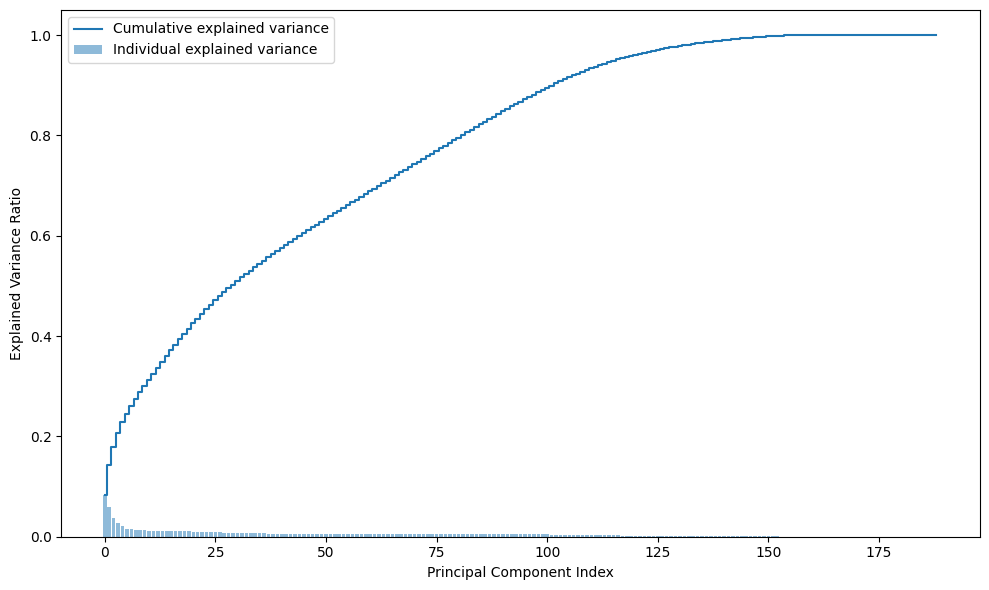

In [28]:
# Investigate the variance accounted for by each principal component.
#calculate cumulative variance
cumu_var = exp_var.cumsum()

#plot variances
plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cumu_var)), cumu_var, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.tight_layout()


In [29]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
data_pca_reduced = pca.fit_transform(azdias)


### Discussion 2.2: Perform Dimensionality Reduction

Based on the graph it appears the elbow of the curve starts around 80-90% explained variance ratio. I will be keeping 100 components, taking the lower end of the elbow as it captures the majority of the data and the workspace kernel fails any higher.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [30]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight(pca, component_number, feature_names):
    '''
    Map weights for the specified component to the related feature name
    Print result sorted by absolute weight value
    
    INPUT:
    pca: trained pca object
    component_number: index of principal component
    feature_names: list of feature names
    
    OUTPUT:
    DataFrame with feature names and corresponding weights
    '''
    
    #get component weights and pair to feature name
    weights = pca.components_[component_number]
    feature_weights = pd.DataFrame(list(zip(feature_names, weights)), columns = ['Feature', 'Weight'])
    
    #sort features by absolute weight value
    feature_weights['Abs_Weight'] = feature_weights['Weight'].abs()
    feature_weights.sort_values('Abs_Weight', ascending=False, inplace=True)
    
    return feature_weights[['Feature', 'Weight']]

azdias_feat_weight_pca1 = pca_weight(pca, 0, azdias.columns)
print(azdias_feat_weight_pca1)

                 Feature    Weight
47            MOBI_REGIO -0.201552
2      FINANZ_MINIMALIST -0.194795
110   LP_STATUS_GROB_1.0  0.192304
37           KBA05_ANTG1 -0.190060
29    HH_EINKOMMEN_SCORE  0.180725
..                   ...       ...
175    CAMEO_DEU_2015_7E  0.000698
130      GEBAEUDETYP_5.0  0.000356
168    CAMEO_DEU_2015_6D -0.000340
167    CAMEO_DEU_2015_6C  0.000229
89   LP_FAMILIE_FEIN_6.0 -0.000229

[189 rows x 2 columns]


In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

azdias_feat_weight_pca2 = pca_weight(pca, 1, azdias.columns)
print(azdias_feat_weight_pca2)

                   Feature    Weight
185                 DECADE -0.229061
0     ALTERSKATEGORIE_GROB  0.226853
13               SEMIO_REL -0.215461
3            FINANZ_SPARER -0.213310
6    FINANZ_UNAUFFAELLIGER -0.207238
..                     ...       ...
145      CAMEO_DEU_2015_1E -0.001386
165      CAMEO_DEU_2015_6A -0.000658
164      CAMEO_DEU_2015_5F  0.000639
143      CAMEO_DEU_2015_1C -0.000621
130        GEBAEUDETYP_5.0  0.000330

[189 rows x 2 columns]


In [32]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

azdias_feat_weight_pca3 = pca_weight(pca, 2, azdias.columns)
print(azdias_feat_weight_pca3)

               Feature    Weight
1            ANREDE_KZ -0.341359
15          SEMIO_VERT  0.319916
22          SEMIO_KAEM -0.312348
21           SEMIO_DOM -0.279711
20          SEMIO_KRIT -0.259574
..                 ...       ...
25             SOHO_KZ  0.000362
168  CAMEO_DEU_2015_6D -0.000311
157  CAMEO_DEU_2015_4D -0.000159
159  CAMEO_DEU_2015_5A -0.000135
170  CAMEO_DEU_2015_6F  0.000045

[189 rows x 2 columns]


### Discussion 2.3: Interpret Principal Components

The results can provide insight into the structure of the data and the interaction between variables. For example, PC1 appears to represent finacial status, contrasting higher finacial status with stability and lower finacial status with higher mobility. PC2 may represent age and cultural attitudes. PC3 might be encapsulating gender differences and contrasting personality traits.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [33]:
from sklearn.cluster import KMeans
import pickle
#cluster range
cluster_count = range(10, 31)

for k in cluster_count:
    #create and fit kmean
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca_reduced)

    #save models as kernel kept restarting
    model_filename = f'kmeans_model_{k}_clusters.pkl'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(kmeans, model_file)
    
    print(f'KMeans model saved to {model_filename} for {k} clusters')

/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_10_clusters.pkl for 10 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_11_clusters.pkl for 11 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_12_clusters.pkl for 12 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_13_clusters.pkl for 13 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_14_clusters.pkl for 14 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_15_clusters.pkl for 15 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_16_clusters.pkl for 16 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_17_clusters.pkl for 17 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_18_clusters.pkl for 18 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_19_clusters.pkl for 19 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_20_clusters.pkl for 20 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_21_clusters.pkl for 21 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_22_clusters.pkl for 22 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_23_clusters.pkl for 23 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_24_clusters.pkl for 24 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_25_clusters.pkl for 25 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_26_clusters.pkl for 26 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_27_clusters.pkl for 27 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_28_clusters.pkl for 28 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_29_clusters.pkl for 29 clusters


/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans model saved to kmeans_model_30_clusters.pkl for 30 clusters


In [34]:
#avg within-cluster difference
avg_distances = []

for k in cluster_count:
    #load model files
    model_filename = f'kmeans_model_{k}_clusters.pkl'
    with open(model_filename, 'rb') as model_file:
        kmeans = pickle.load(model_file)
    
    #calculate the negative of the avg within-cluster difference
    avg_distance = -kmeans.score(data_pca_reduced) / data_pca_reduced.shape[0]
    avg_distances.append(avg_distance)
    

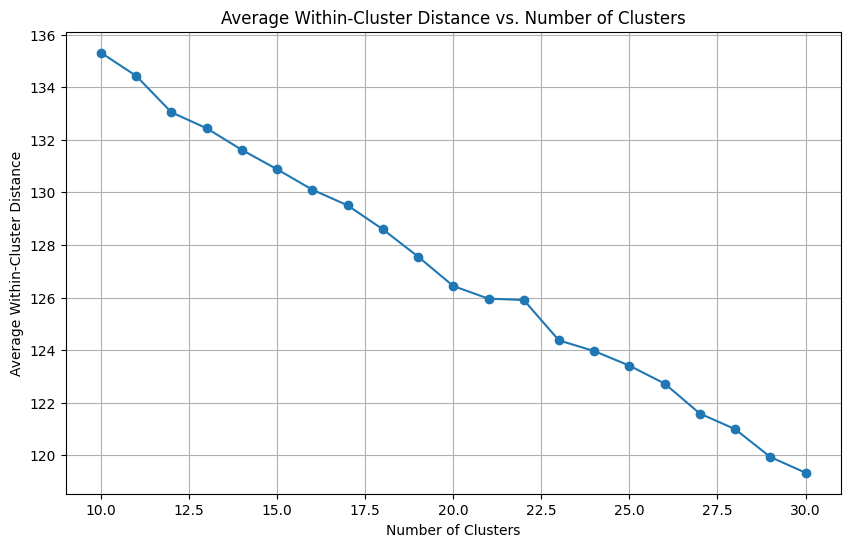

In [35]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

#plot average distance
plt.figure(figsize=(10,6))
plt.plot(cluster_count, avg_distances, marker='o')
plt.title('Average Within-Cluster Distance vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.grid(True)
plt.show()

In [36]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_optimal = KMeans(n_clusters=20, random_state=42)
kmeans_optimal.fit(data_pca_reduced)

cluster_assignments = kmeans_optimal.labels_

/home/kao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Discussion 3.1: Apply Clustering to General Population

There is no clear elbow for clusters 10-30, I have decided to use 20 clusters. The gains in reducing the average within-cluster distance seems to diminish after this point. Additionally, the time and computational cost significantly increases. I believe this will be a good balance between not having enough clusters to capture diversity and having too many that are harder to interpret or overfitting the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [40]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')



In [41]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

customers = scaler.transform(customers)

customer_data_pca = pca.transform(customers)

customer_clusters = kmeans_optimal.predict(customer_data_pca)


/tmp/ipykernel_2912/1863755359.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
/home/kao/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

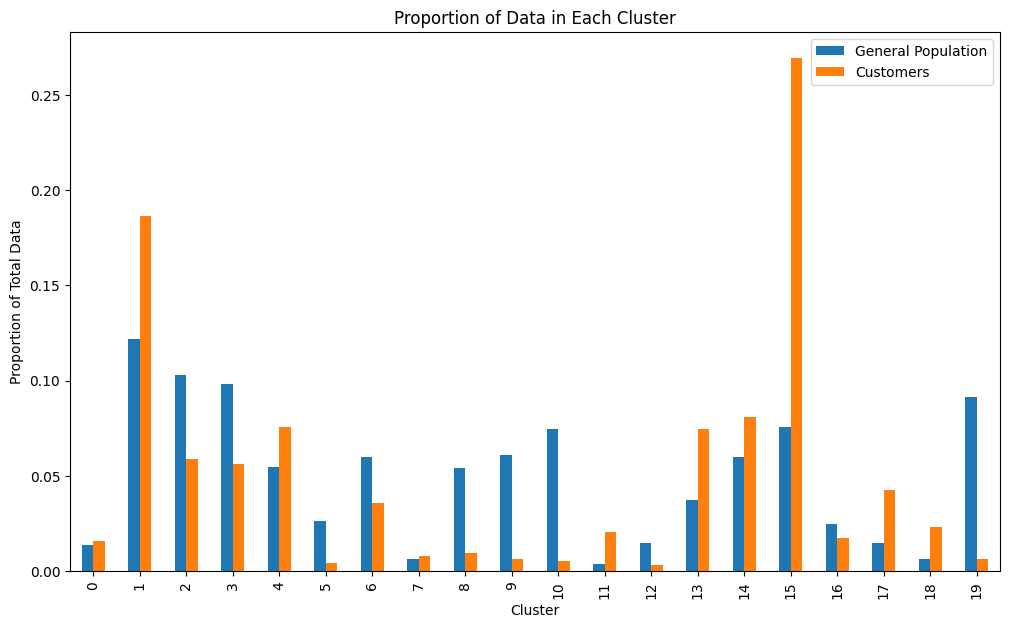

In [42]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#calculate proportions of each cluster
general_population_proportions = (
    pd.Series(cluster_assignments).value_counts(normalize=True).sort_index()
)

customer_proportions = (
    pd.Series(customer_clusters).value_counts(normalize=True).sort_index()
)

#create new dataframe from proportions
df_comparison = pd.DataFrame({
    'General Population': general_population_proportions,
    'Customers': customer_proportions
})

#plot distributions
df_comparison.plot(kind='bar', figsize=(12, 7))
plt.title('Proportion of Data in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Total Data')
plt.show()

In [43]:
#find difference in proportions
df_comparison['Difference'] = df_comparison['Customers'] - df_comparison['General Population']

#sort by difference to get over/underrepresented clusters
df_comparison_sorted = df_comparison.sort_values('Difference', ascending=False)

print(df_comparison_sorted)

    General Population  Customers  Difference
15            0.075618   0.269571    0.193953
1             0.121576   0.186583    0.065007
13            0.037063   0.074393    0.037330
17            0.014924   0.042761    0.027837
14            0.059624   0.081025    0.021402
4             0.054770   0.075500    0.020730
18            0.006314   0.022959    0.016644
11            0.003904   0.020252    0.016348
0             0.013678   0.015825    0.002147
7             0.006077   0.007990    0.001913
16            0.024696   0.017303   -0.007393
12            0.014579   0.003139   -0.011440
5             0.026020   0.004246   -0.021774
6             0.059868   0.035886   -0.023981
3             0.097932   0.056294   -0.041638
2             0.102659   0.058793   -0.043866
8             0.054000   0.009685   -0.044315
9             0.060914   0.006330   -0.054584
10            0.074420   0.005266   -0.069153
19            0.091366   0.006200   -0.085166


In [45]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Get centroid of overrepresented cluster
overrepresented_centroids = kmeans_optimal.cluster_centers_[df_comparison_sorted.index[0]]

# Reshape the centroid to have the proper 2D shape
overrepresented_centroids_reshaped = overrepresented_centroids.reshape(1, -1)

# Inverse transform the reshaped centroid using PCA and then the scaler
overrepresented_centroids_pca = pca.inverse_transform(overrepresented_centroids_reshaped)
overrepresented_centroids_original = scaler.inverse_transform(overrepresented_centroids_pca)

# Convert to series for easier handling
over_series = pd.Series(overrepresented_centroids_original.flatten(), index=azdias.columns)

# Sort by absolute value to get feature characteristics
over_series_sorted = over_series.abs().sort_values(ascending=False)

# Filter top 5 from absolute sorted results and over original series to retain their positive or negative values
top_features = over_series_sorted.head(5).index
top_features_weights = over_series[top_features]

print(top_features_weights)


MIN_GEBAEUDEJAHR    1992.522955
KBA13_ANZAHL_PKW     683.172173
DECADE                59.673016
WOHNDAUER_2008         8.644775
SEMIO_LUST             5.739078
dtype: float64


In [47]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Get centroid of underrepresented cluster
underrepresented_centroids = kmeans_optimal.cluster_centers_[df_comparison_sorted.index[-1]]

# Reshape the centroid to have the proper 2D shape
underrepresented_centroids_reshaped = underrepresented_centroids.reshape(1, -1)

# Inverse transform the reshaped centroid using PCA and then the scaler
underrepresented_centroids_pca = pca.inverse_transform(underrepresented_centroids_reshaped)
underrepresented_centroids_original = scaler.inverse_transform(underrepresented_centroids_pca)

# Convert to series for easier handling
under_series = pd.Series(underrepresented_centroids_original.flatten(), index=azdias.columns)

# Sort by absolute value to get feature characteristics
under_series_sorted = under_series.abs().sort_values(ascending=False)

# Filter top 5 from absolute sorted results and over original series to retain their positive or negative values
under_top_features = under_series_sorted.head(5).index
under_top_features_weights = under_series[under_top_features]

print(under_top_features_weights)


MIN_GEBAEUDEJAHR       1992.330044
KBA13_ANZAHL_PKW        523.685172
DECADE                   87.328645
ANZ_HAUSHALTE_AKTIV      14.716209
WOHNDAUER_2008            7.178975
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

The data shows us that the company appears to perform better with individuals that live in a newer building and younger audience compared to the general demographic. Their customers also tend to have a higher number of cars, this could indicate a suburban area or a better financial status. The company may appeal to individuals that have specific lifestyle, cultural or social characteristics that impact their consumer behavior and that the company satifies.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.